In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda:{}'.format(0) if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(device) # change allocation of current GPU 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

Generete dataset

In [7]:
sensor_num = 11
sensor_list = [f'Sensor_{num}' for num in range(1, sensor_num + 1)]

classes = [0, 1]
class_probabilities = [0.9, 0.1]

min_data_length, max_data_length = 90, 102
data_cycle_num = 5
data_num = 50

dataset_df_list = []

for cycle in range(1, data_cycle_num + 1):
    for data_index in range(data_num):
        sampling_size = random.sample(range(min_data_length, max_data_length), 1)[0]
        class_label = random.choices(classes, class_probabilities, k=1)[0]    

        generation_array = np.random.rand(sampling_size, sensor_num)
        generation_df = pd.DataFrame(generation_array, columns=sensor_list)
        generation_df['cycle'] = cycle
        generation_df['key'] = data_index
        generation_df['label'] = class_label
        
        dataset_df_list.append(generation_df)

concat_df = pd.concat(dataset_df_list, axis=0).reset_index(drop=True)

Get cycle statistic

In [11]:
data_key_list = ['key','cycle']

cycle_num = concat_df.cycle.unique()
cycle_dict = {}

c_m_list = []
c_s_list = []

for cycle in cycle_num:
    cycle_df = concat_df[concat_df.cycle == cycle]
    wafer_unit = list(cycle_df.groupby(data_key_list)) # KEY 값

    w_mean = np.array([df.loc[:, sensor_list].mean().values for info, df in wafer_unit])
    w_std = np.array([df.loc[:, sensor_list].std().values for info, df in wafer_unit])

    c_mean = np.mean(w_mean, axis = 0)
    c_m_list.append(c_mean)
    
    c_std = np.mean(w_std, axis = 0)
    c_s_list.append(c_std)
    
cycle_dict['mean'] = np.array(c_m_list)
cycle_dict['std'] = np.array(c_s_list)

Split data

In [13]:
from sklearn.model_selection import train_test_split

wafer_list = list(concat_df.groupby(data_key_list)) # KEY 값

X_train_, X_test, y_train, y_test = train_test_split(wafer_list, range(len(wafer_list)), test_size = 0.1, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_, range(len(X_train_)), test_size = 0.1, random_state=42)

split_data = [X_train, X_valid, X_test]

for data in split_data:
    print(pd.Series([wafer[1].label.unique()[0] for wafer in data]).value_counts())

0    183
1     19
Name: count, dtype: int64
0    18
1     5
Name: count, dtype: int64
0    22
1     3
Name: count, dtype: int64


Dataset

In [18]:
class datasetAE(Dataset):
    def __init__(self, wafer_unit, window_size, max_len, cycle_dict, sensor_list):
        
        super(datasetAE, self).__init__()
        self.wafer_unit = wafer_unit
        self.window_size = window_size
        self.max_len = max_len
        self.cycle_dict = cycle_dict
    
    def __getitem__(self, idx):
        
        info = self.wafer_unit[idx][0]
        df = self.wafer_unit[idx][1].reset_index(drop=True)
    
        c_mean = self.cycle_dict['mean'][0]
        c_std = self.cycle_dict['std'][0]
        y = df.label.unique()[0]
        
        sensor_df = df.loc[:, sensor_list].reset_index(drop=True)
                
        # padding length
        if len(sensor_df) < self.max_len:
            new_index = list(range(self.max_len))
            sensor_df = sensor_df.reindex(new_index).ffill()
                
        sensor_array = np.array(sensor_df)
        
        # nomralization with cycle mean and std
        normed_array = (sensor_array - c_mean) / (c_std)
        
        # (time_length, sensor_num) -> (sensor_num, time_length)
        x = np.array(normed_array).T
        # get sliding windows
        windows_x = np.lib.stride_tricks.sliding_window_view(x, self.window_size, 1)
        
        return np.array(windows_x), np.array(y)
    
    def __len__(self):
        return len(self.wafer_unit)

In [19]:
max_len = max(set([len(wafer[1]) for wafer in wafer_list]))

train_dataset = datasetAE(X_train, 70, max_len, cycle_dict, sensor_list)
valid_dataset = datasetAE(X_valid, 70, max_len, cycle_dict, sensor_list)
test_dataset = datasetAE(X_test, 70, max_len, cycle_dict, sensor_list)

train_loader = DataLoader(train_dataset, batch_size=64, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1)

Model

In [21]:
class MTS_CNN(torch.nn.Module):
    
    def __init__(self, sensor_num):
        super(MTS_CNN, self).__init__()
           
        extract_list = []
        diagnosis_list = []
        for num in range(sensor_num):
            
            extract_layer = torch.nn.Sequential(
                    torch.nn.Conv1d(in_channels = 32, out_channels = 16, 
                                    kernel_size = 5),
                    torch.nn.ReLU(),
                    torch.nn.AvgPool1d(kernel_size = 3, stride = 3),
                    torch.nn.Conv1d(in_channels = 16, out_channels = 64, 
                                    kernel_size = 5),
                    torch.nn.ReLU(),
                    torch.nn.AvgPool1d(kernel_size = 3, stride = 3),
            )

            
            diagnosis_layer = torch.nn.Sequential(
                     torch.nn.Linear(384, 256),
                     torch.nn.ReLU(),
                     torch.nn.Linear(256, 1),
                     torch.nn.Dropout(0.5),
                     torch.nn.ReLU(),
            )
            
            extract_list.append(extract_layer)
            diagnosis_list.append(diagnosis_layer)
        
        self.extract_layer = nn.ModuleList(extract_list)
        self.diagnosis_layer = nn.ModuleList(diagnosis_list)
        
        self.detection_layer = torch.nn.Sequential(
                                             torch.nn.Linear(sensor_num, 32),
                                             torch.nn.ReLU(),
                                             torch.nn.Linear(32, 16),
                                             torch.nn.Dropout(0.5),
                                             torch.nn.ReLU(),
                                             torch.nn.Linear(16, 2)
                                    )

    def forward(self, x):
        batch_size, sensor_num, sequence, window_size = x.shape

        # (batch_size, sensor_num, sequence, window_size) -> (sensor_num, batch_size, sequence, window_size)
        x_ = x.transpose(1,0)

        # 센서 별로 convolution 적용        
        stack_sensor = []
        for sensor_num, x__ in enumerate(x_):
            
            # (batch_size, sequence, window_size)
            # Feature Extraction Layer
            feature = self.extract_layer[sensor_num](x__)
            
            # (batch_size, (*feature_size))
            flatten = feature.view(batch_size, -1)
            # Fault Diagnosis Layer 
            diagnosis = self.diagnosis_layer[sensor_num](flatten)
            # (batch_size, 1)
            stack_sensor.append(diagnosis)
        
        # Stack By Sensor
        # (sensor_num, batch_size, 1) -> (batch_size, sensor_num)
        fin_stack = torch.stack(stack_sensor).transpose(0,1).squeeze()
        # Fault Detection Layer
        output = self.detection_layer(fin_stack)

        return output, fin_stack

In [22]:
test_tensor = torch.rand(64, 11, 32, 70)
model = MTS_CNN(11)
output, fin_stack = model(test_tensor)

Get sensor importance

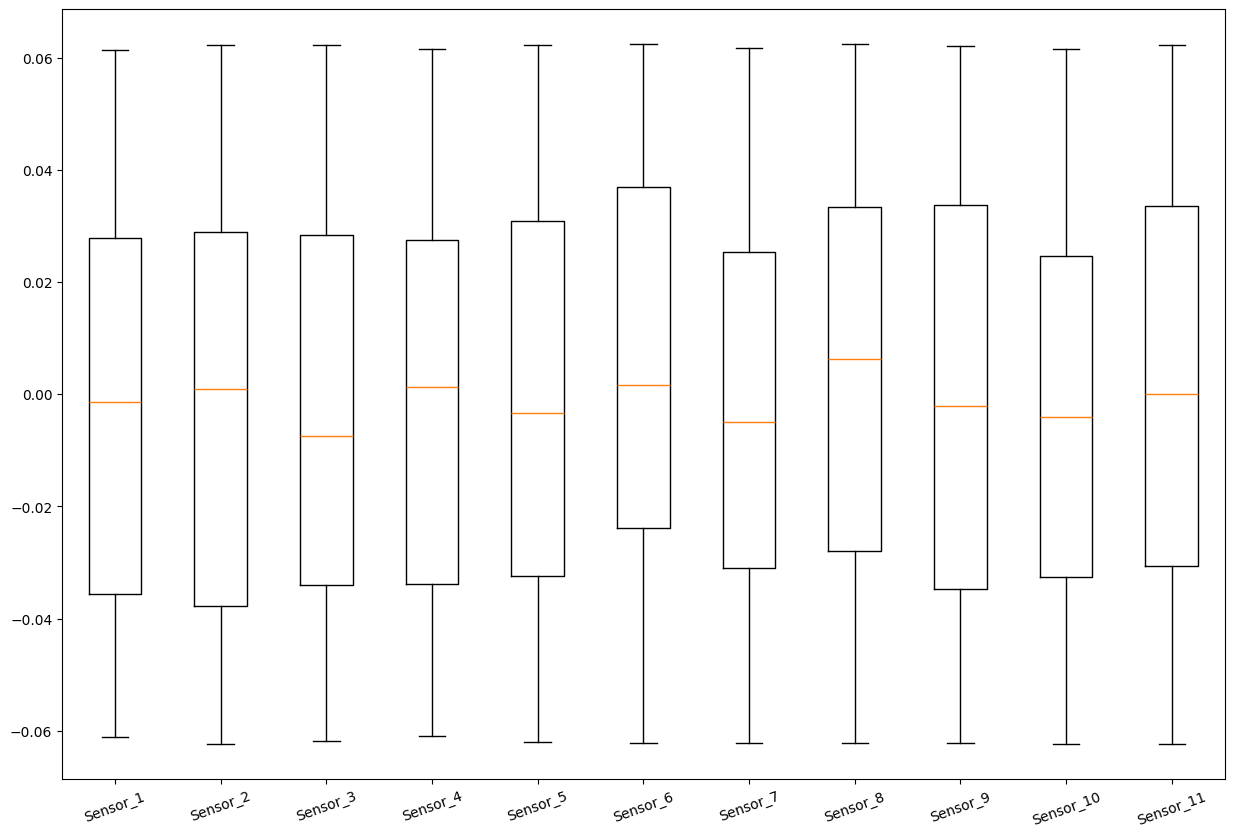

In [23]:
weight_dict = {}
for name, param in model.named_parameters():
    layer_name = name.split('.')[0]
    if layer_name == 'diagnosis_layer':
        if name.split('.')[-2] == '2' and name.split('.')[-1] == 'weight':
            sensor_weight = param.detach().cpu().numpy()
            weight_dict[name] = sensor_weight.reshape(-1)


plt.figure(figsize = [15, 10])
box_list = []
for sensor_weight in list(weight_dict.values()):
    box_list.append(sensor_weight)
    
plt.boxplot(box_list)
plt.xticks(range(1, 12), sensor_list,  rotation=20)
plt.show()